In [1]:
import jax
from flax import linen as nn
import jax.numpy as jnp
import optax
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
def plot_1d_gaussian(mu, cov):
    x = jnp.linspace(0,10,100)
    pdf = jax.vmap(jax.scipy.stats.multivariate_normal.logpdf, in_axes=(0,None,None))(x,mu, cov)
    plt.plot(x,pdf)

In [ ]:
x = jnp.linspace(0,1,1000)
y = x*0.1
samples = jnp.stack([x,y], axis=1)
# jax.vmap(jax.scipy.stats.multivariate_normal.logpdf, in_axes=(0,None,None))(samples,jnp.ones(2), jnp.eye(2))
# samples = jax.random.multivariate_normal(jax.random.PRNGKey(12346), jnp.array([5]), jnp.array([[10.0]]), shape=(1000,))

In [26]:
def gaussian_mixture_logpdf(samples, means, covs):
    
    normals_log_prob = jax.scipy.stats.multivariate_normal.logpdf(samples, means, covs)
    
    return normals_log_prob


def get_cov_matrices_from_vectors(covariance_terms, num_means, eps):
    x = covariance_terms
    output_shape = (num_means, num_means)
    x = jnp.concatenate([x, x[num_means:][::-1]])
    x = x.reshape(output_shape)
    x = jnp.triu(x)

    eps = jnp.eye(num_means) * eps
    cov_matrices = jnp.matmul(x, x.swapaxes(-2,-1)) + eps
    return cov_matrices

In [27]:
class MultiVariateNormal(nn.Module):
    
    @nn.compact
    def __call__(self, samples, mu, cov_terms):
        mu = self.param('mu',
                    nn.initializers.constant(1.0), # Initialization function
                    (2,)) 
        cov = self.param('cov',
                    nn.initializers.uniform(1.0), # Initialization function
                    (3,)) 
        cov = get_cov_matrices_from_vectors(cov, 2, 1e-5)
        return jax.vmap(jax.scipy.stats.multivariate_normal.logpdf, in_axes=(0,None,None))(samples,mu, cov)

def update_step(apply_fn, samples, opt_state, params, mu, cov_terms):
    def loss(params):
        l = apply_fn(params, samples, mu, cov_terms)
        return -l.sum()
    
    l, grads = jax.value_and_grad(loss, has_aux=False)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, l


In [28]:
m = MultiVariateNormal()
params = m.init(jax.random.PRNGKey(567), samples, jnp.array([0.5,0.5]), jnp.array([1.0,0.0,1.0]))
tx = optax.adam(learning_rate=0.01)
opt_state = tx.init(params)

mu = params['params']['mu']
# mu = jnp.array([0.5,0.5])
cov = params['params']['cov']
# cov_matrix = get_cov_matrices_from_vectors(cov[None,None], 2, 1e-5)[0,0]
# cov_matrix = jnp.array([[0.7,0.1],[0.1,0.1]]) + 1e-5 * jnp.eye(2)
for i in range(10000):
    opt_state, params, l = jax.jit(update_step, static_argnums=(0,))(m.apply, samples, opt_state, params, jnp.array([0.5,0.5]), jnp.array([1.0,0.0,1.0]))
    # opt_state, params, l = update_step(m.apply, samples, opt_state, params, jnp.array([0.5,0.5]), jnp.array([1.0,0.0,1.0]))
    if i % 1000 == 0:
        print(l)
        print(params)


1756.822
FrozenDict({
    params: {
        cov: DeviceArray([0.32980192, 0.7445024 , 0.99040306], dtype=float32),
        mu: DeviceArray([1.0100002, 0.9899998], dtype=float32),
    },
})
-4655.073
FrozenDict({
    params: {
        cov: DeviceArray([-2.4385407e-22,  2.8894079e-01,  2.8894471e-02], dtype=float32),
        mu: DeviceArray([0.5       , 0.04999998], dtype=float32),
    },
})
-4638.4507
FrozenDict({
    params: {
        cov: DeviceArray([-7.0064923e-45,  2.9573008e-01,  2.9165825e-02], dtype=float32),
        mu: DeviceArray([0.4980905, 0.050087 ], dtype=float32),
    },
})
-4654.289
FrozenDict({
    params: {
        cov: DeviceArray([0.        , 0.28956494, 0.02907191], dtype=float32),
        mu: DeviceArray([0.50003415, 0.05000147], dtype=float32),
    },
})
-4642.3594
FrozenDict({
    params: {
        cov: DeviceArray([0.        , 0.2924682 , 0.02910043], dtype=float32),
        mu: DeviceArray([0.499997  , 0.04999879], dtype=float32),
    },
})
-4655.0674
FrozenDi

In [48]:
def plot_gaussian(mu, sigma):
    x = jnp.linspace(-0,1)
    y = jnp.linspace(-0,1)
    X,Y = jnp.meshgrid(x,y)
    XX = jnp.array([X.ravel(), Y.ravel()]).T
    print(XX[-10:])
    Z = jax.vmap(jax.scipy.stats.multivariate_normal.logpdf, in_axes=(0,None,None))(XX, mu, sigma)
    Z = Z.reshape(X.shape)
    plt.contour(X,Y,Z,)

[[0.8163265  1.        ]
 [0.83673465 1.        ]
 [0.85714287 1.        ]
 [0.877551   1.        ]
 [0.8979592  1.        ]
 [0.9183673  1.        ]
 [0.9387755  1.        ]
 [0.95918363 1.        ]
 [0.97959185 1.        ]
 [1.         1.        ]]


DeviceArray([[0.08327462, 0.00846354],
             [0.00846354, 0.00087029]], dtype=float32)

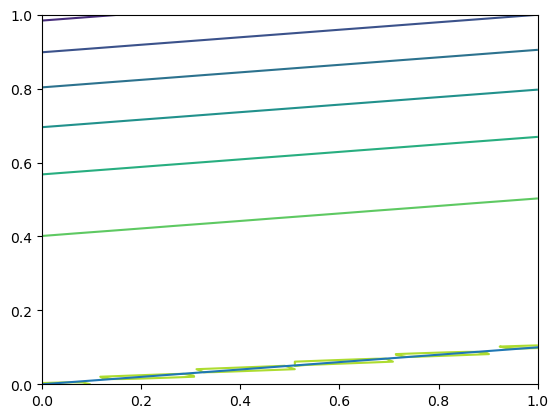

In [50]:
mu = params['params']['mu']
# mu = jnp.array([0.5,0.5])
cov = params['params']['cov']
cov_matrix = get_cov_matrices_from_vectors(cov, 2, 1e-5)
# cov_matrix = jnp.array([[0.7,0.1],[0.1,0.1]]) + 1e-5 * jnp.eye(2)
# plot_1d_gaussian(mu, cov)
# mu = params['params']['parameters'][:2]
# # mu = jnp.array([0.5,0.5])
# cov = params['params']['parameters'][2:]
# cov_matrix = get_cov_matrices_from_vectors(cov[None,None], 2, 1e-5)[0,0]
# # cov_matrix = jnp.array([[0.7,0.1],[0.1,0.1]]) + 1e-5 * jnp.eye(2)
plot_gaussian(mu, cov_matrix)
plt.plot(x,y)
# plt.scatter(samples[:,0], samples[:,1])
cov_matrix
# points = jax.random.multivariate_normal(key, mu, cov_matrix, (1000,))
# # plt.scatter(points[:,0], points[:,1])
# cov_matrix
# print(jax.vmap(jax.scipy.stats.multivariate_normal.logpdf, in_axes=(0,None,None))(samples, mu, cov).sum())
# print(jax.vmap(jax.scipy.stats.multivariate_normal.logpdf, in_axes=(0,None,None))(samples, jnp.array([0.5]), jnp.array([[10.0]])).sum())